In [305]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [5]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
print(df.describe())
print(df.shape)

               step        amount  oldBalanceOrig  newBalanceOrig  \
count  6.362620e+06  6.362620e+06    6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05    8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05    2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00    0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04    0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04    1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05    1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07    5.958504e+07    4.958504e+07   

       oldBalanceDest  newBalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.0

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'], dtype=object)

In [15]:
print("過去実績として、マネーロンダリングの可能性のある取引は{}の場合です".format(list(df.loc[df.isFraud==1].type.drop_duplicates().values)))

過去実績として、マネーロンダリングの可能性のある取引は['TRANSFER', 'CASH_OUT']の場合です


In [16]:
dfFraudTransfer = df[(df.isFraud==1)&(df.type=="TRANSFER")]
dfFraudCashout = df[(df.isFraud==1)&(df.type=="CASH_OUT")]

In [19]:
print(dfFraudTransfer.shape,dfFraudCashout.shape)

(4097, 11) (4116, 11)


In [20]:
print("isFlaggedFraud列でフラグが立っているのは、取引が{}のものです。".format(list(df.loc[df["isFlaggedFraud"]==1].type.drop_duplicates())))


dfTransfer = df[df.type=="TRANSFER"]
dfFlagged = df[df.isFlaggedFraud==1]
dfNotFlagged = df[df.isFlaggedFraud==0]

print("isFlaggedFraud列でフラグが立っている取引の内、最小の金額は{}です。".format(dfFlagged.amount.min()))
print("isFlaggedFraud列でフラグが立っている取引の内、最大の金額は{}です。".format(dfFlagged.amount.max()))


isFlaggedFraud列でフラグが立っているのは、取引が['TRANSFER']のものです。
isFlaggedFraud列でフラグが立っている取引の内、最小の金額は353874.22です。
isFlaggedFraud列でフラグが立っている取引の内、最大の金額は10000000.0です。


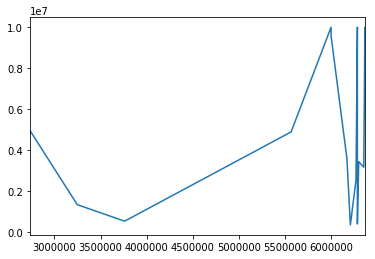

In [21]:
dfFlagged.amount.plot();

In [22]:
print("isFlaggedFraud=1でないと、送ることができないかを検討する。以下にある通り、必ずしもそうではない")

print("TRANSFERのうち、isFlaggedFraud=0でありながら、oldBalance=0でnewBalance=0の数は{}".format(len(dfTransfer[(dfTransfer.isFlaggedFraud==0) &(dfTransfer.oldBalanceDest==0)&(dfTransfer.newBalanceDest==0)])))

isFlaggedFraud=1でないと、送ることができないかを検討する。以下にある通り、必ずしもそうではない
TRANSFERのうち、isFlaggedFraud=0でありながら、oldBalance=0でnewBalance=0の数は4158


In [23]:
print('typeがTRANSFERでisFlaggedFraud=1の時のoldBalanceOrigの最大、最小: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('typeがTRANSFERでisFlaggedFraud=0の時の、oldBalanceOrig=newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))

print("データとして被っており、特徴があるものとは言えない")

typeがTRANSFERでisFlaggedFraud=1の時のoldBalanceOrigの最大、最小: [353874.0, 19585040.0]
typeがTRANSFERでisFlaggedFraud=0の時の、oldBalanceOrig=newBalanceOrig: [0.0, 575668.0]
データとして被っており、特徴があるものとは言えない


In [24]:
print("1度isFlaggedFraud=1になったoriginalアカウントがisFraggedFraud=0の中で取引をしているか?:{}".format(dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, dfNotFlagged.nameDest])).any()))
print("1度isFlaggedFraud=1になった送り先アカウントがisFraggedFraud=0の中で取引をしているか?:{}".format(dfFlagged.nameDest.isin(dfNotFlagged.nameOrig).any()))

print("1度isFlaggedFraud=1になった送りアカウントがisFraggedFraud=0の中で再度取引をしているか?:{}".format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))))

1度isFlaggedFraud=1になったoriginalアカウントがisFraggedFraud=0の中で取引をしているか?:False
1度isFlaggedFraud=1になった送り先アカウントがisFraggedFraud=0の中で取引をしているか?:False
1度isFlaggedFraud=1になった送りアカウントがisFraggedFraud=0の中で再度取引をしているか?:2


## 【結論】isFlaggedFraudはデータの偏りはないため、削除できる

### 犯罪の手口として、最初にTRANSTERを行い、その後、Fraud用の口座にCASHOUTとして送金するパターンが多いため、それを探る

In [25]:
print('isFraud=1になっておりTransferのあとにCASHPUTになっているものはあるか？ {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) 
dfNotFraud = df.loc[df.isFraud == 0]

isFraud=1になっておりTransferのあとにCASHPUTになっているものはあるか？ False


In [26]:
print("オリジナルはfraudではない状態で1度取引したものの、その後、真のCASHOUTに関わらずFraudとして検知されたものがあるか？：{}".format(dfFraudTransfer[dfFraudTransfer.nameDest.isin(dfNotFraud[dfNotFraud.type=="CASH_OUT"].nameOrig.drop_duplicates())]))

オリジナルはfraudではない状態で1度取引したものの、その後、真のCASHOUTに関わらずFraudとして検知されたものがあるか？：         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [27]:
print('\FraudのTRANSFERとしてC423543548にstep486が表示されている、一方、本当のCASH_OUTが最初にCASHOUTとしてある {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values)) # 185

\FraudのTRANSFERとしてC423543548にstep486が表示されている、一方、本当のCASH_OUTが最初にCASHOUTとしてある [185]


## 【結論】nameOrigおよびnameDesは重要なものではない為、データから外す

## データクリーニングパート

In [63]:
X = df[(df.type=="TRANSFER")|(df.type=="CASH_OUT")]

In [64]:
X.shape

(2770409, 11)

In [65]:
randomState = 0
np.random.seed(randomState)

In [66]:
X.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [67]:
Y = X["isFraud"]
del X["isFraud"]

In [68]:
X = X.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

In [69]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89


In [70]:
#encoding
X.loc[X.type=="TRANSFER", "type"] = 0
X.loc[X.type=="CASH_OUT", "type"] = 1
X.type = X.type.astype(int)

In [71]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [72]:
Xfraud = X[Y==1]
XnonFraud = X[Y==0]

print("取引のamountが0でないにも関わらず、oldBalanceDest=newBBalanceDest=0であるFraudの割合:{}".format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print("取引のamountが0でないにも関わらず、oldBalanceDest=newBBalanceDest=0であるNon Fraudの割合:{}".format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))

取引のamountが0でないにも関わらず、oldBalanceDest=newBBalanceDest=0であるFraudの割合:0.4955558261293072
取引のamountが0でないにも関わらず、oldBalanceDest=newBBalanceDest=0であるNon Fraudの割合:0.0006176245277308345


### oldBalanceDestとnewBalanceDestが０で、金額が０でないものは、Fraudの可能性が非常に高いので、区別しておく

In [73]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), ['oldBalanceDest', 'newBalanceDest']]=-1

In [74]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [75]:
#同様の理由で以下も区別
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

## Feature engineeringとして新たに2変数を追加する。

In [76]:
X["errorBalanceOrig"] = X.newBalanceOrig + X.amount -X.oldBalanceOrig
X["errorBalanceDest"] = X.newBalanceDest + X.amount -X.oldBalanceDest

In [77]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00,0.00,181.00
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,-21001.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,275564.38
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,192885.30
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,3024591.78


## Data Visualizeを通して、データの理解を実施する

In [43]:
# 準備
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

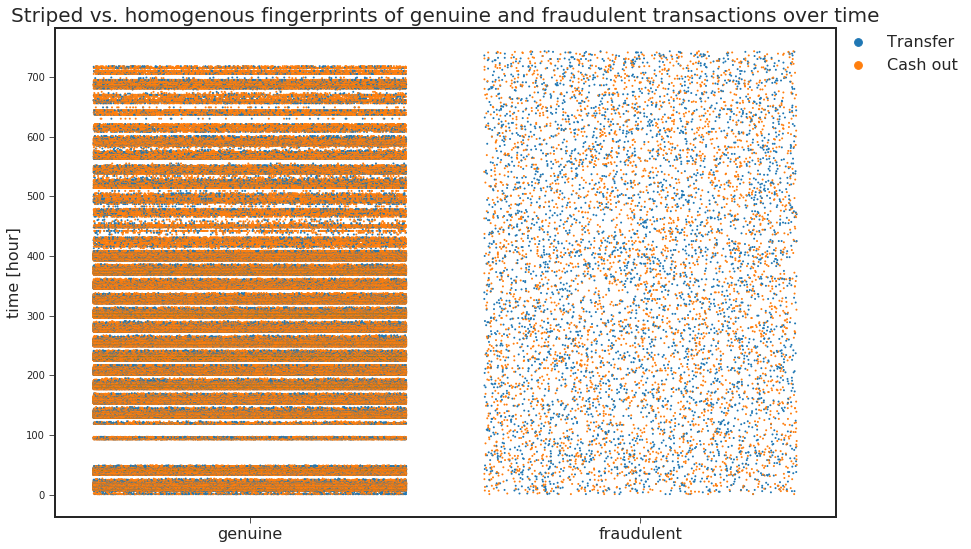

In [44]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

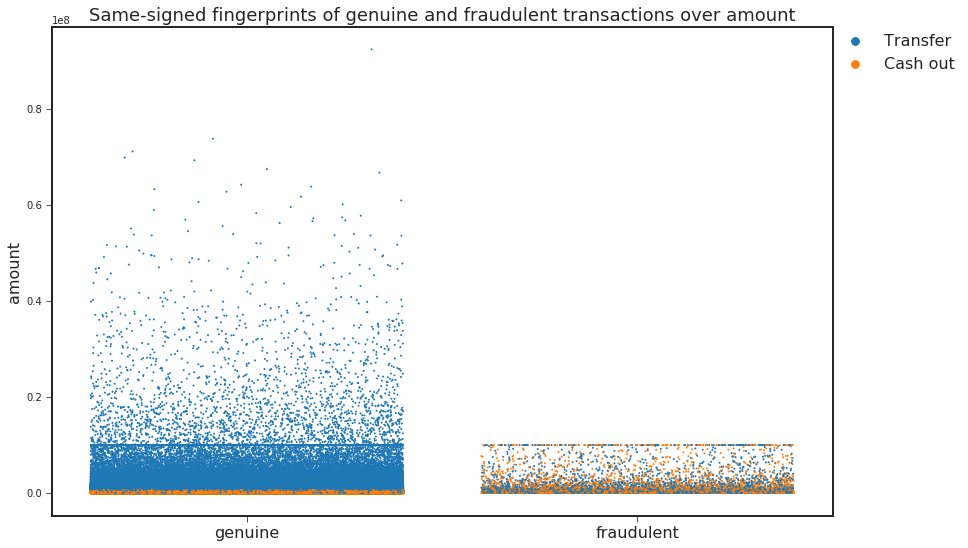

In [45]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

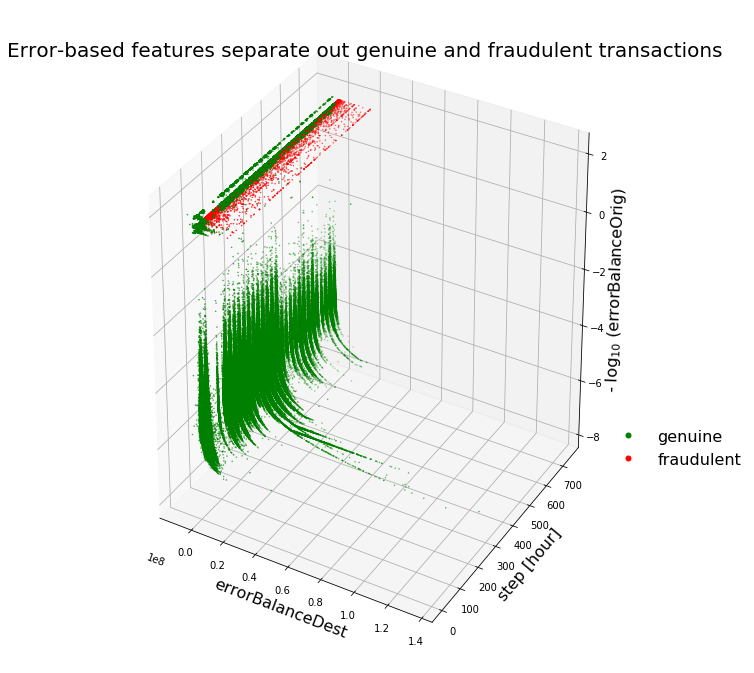

In [46]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

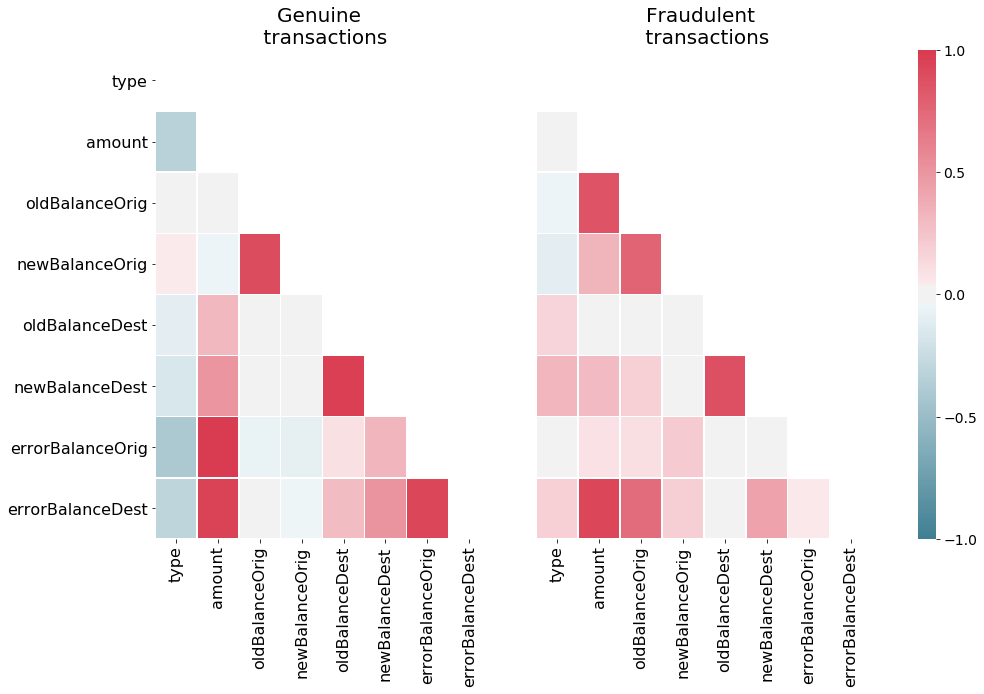

In [47]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

## 主成分分析（PCA）を使って、第１主成分から第３主成分までをプロットし、クラスタリングできないかを検討

In [89]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [84]:
sc = StandardScaler()
X_= X[X.isnull()==0]

In [145]:
X_ = sc.fit_transform(X_)

In [183]:
n=9
X_pca = PCA(n_components=n).fit_transform(X_)
pca = PCA(n_components=n).fit(X_)

In [184]:
pca_explained_variance_ratio_ = pca.explained_variance_ratio_

(-49.165229935571489, 85.903489534969182)

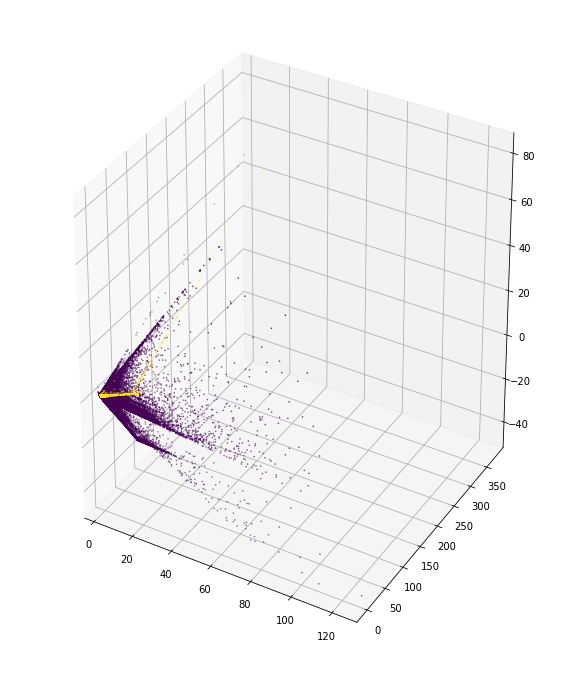

In [126]:
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:,0], X_pca[:,1],X_pca[:,2], c = Y, marker = '.',s = 1)
ax.set_xlim3d([X_pca[:,0].min(),X_pca[:,0].max()])
ax.set_ylim3d([X_pca[:,1].min(),X_pca[:,1].max()])
ax.set_zlim3d([X_pca[:,2].min(),X_pca[:,2].max()])

In [135]:
#2次元でマッピングすると以下の通り

Text(0,0.5,'The second factor : ratio 0.19907634065771193')

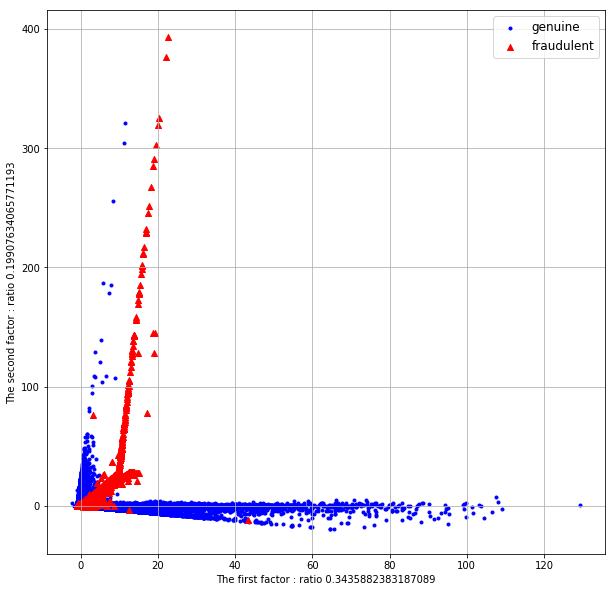

In [152]:
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[Y == 0, 0],X_pca[Y == 0, 1], label='genuine', c="b", marker=".")
plt.scatter(X_pca[Y == 1, 0],X_pca[Y == 1, 1], label='fraudulent', c="r", marker="^")

plt.grid()
plt.legend(loc="best", fontsize=12)
plt.xlabel("The first factor : ratio {}".format(pca_explained_variance_ratio_[0]))
plt.ylabel("The second factor : ratio {}".format(pca_explained_variance_ratio_[1]))

## グラフからわかることは、第２主成分が高いほどFraudの可能性が高まる（説明力は20%と限定的であるが、一定の傾向にある）

In [153]:
X.corr()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
step,1.000000,-0.016022,0.037007,0.005744,-0.011280,0.037778,0.037475,0.026042,0.024251
type,-0.016022,1.000000,-0.326040,-0.013202,0.018726,-0.099794,-0.157024,-0.249691,-0.301144
amount,0.037007,-0.326040,1.000000,0.120389,0.018296,0.307133,0.497027,0.494442,0.957467
oldBalanceOrig,0.005744,-0.013202,0.120389,1.000000,0.778826,-0.020403,-0.010029,0.006779,0.073109
newBalanceOrig,-0.011280,0.018726,0.018296,0.778826,1.000000,-0.012277,-0.015439,-0.024104,-0.002046
oldBalanceDest,0.037778,-0.099794,0.307133,-0.020403,-0.012277,1.000000,0.970060,0.017890,0.292097
newBalanceDest,0.037475,-0.157024,0.497027,-0.010029,-0.015439,0.970060,1.000000,0.140956,0.509700
errorBalanceOrig,0.026042,-0.249691,0.494442,0.006779,-0.024104,0.017890,0.140956,1.000000,0.511404
errorBalanceDest,0.024251,-0.301144,0.957467,0.073109,-0.002046,0.292097,0.509700,0.511404,1.000000


In [185]:
pca.singular_values_

array([  2.92693005e+03,   2.22793761e+03,   2.02679902e+03,
         1.66247002e+03,   1.51071736e+03,   1.23675496e+03,
         7.72569249e+02,   3.50202307e+02,   1.12874483e-11])

In [186]:
X_bar = np.array([row - np.mean(row) for row in X_pca.transpose()]).transpose()
m = np.dot(X_bar.T, X_bar)/X_pca.shape[0]
W, r = np.linalg.eig(m)

In [190]:
print(X.shape, X_.shape, X_pca.shape, r.shape)

(2770409, 9) (2770409, 9) (2770409, 9) (9, 9)


In [227]:
r

array([[ -1.00000000e+00,  -4.27838510e-16,   4.79148152e-14,
          3.29246581e-14,   6.58299502e-14,   4.02253627e-17,
         -1.28749078e-16,   1.13009832e-16,  -6.23145913e-29],
       [ -1.43730677e-15,   1.00000000e+00,   1.33508554e-15,
         -1.47462737e-14,   2.05140056e-15,  -3.81747144e-16,
          4.45722069e-16,   1.73866726e-16,   1.20175780e-28],
       [ -4.75446053e-14,   2.43447725e-16,  -1.00000000e+00,
          3.54265412e-14,  -1.22280933e-13,   1.74845228e-15,
         -3.39398414e-17,  -8.97862110e-17,   1.50960033e-28],
       [  3.25899198e-14,   1.53372941e-14,   3.57539444e-14,
          1.00000000e+00,  -2.71412154e-14,   1.58731265e-14,
         -2.63405674e-15,  -2.09570704e-16,   6.99942137e-29],
       [ -6.55249380e-14,   3.23852041e-15,   1.22380337e-13,
         -2.60089971e-14,  -1.00000000e+00,  -8.36048714e-15,
          4.55584236e-16,   5.55946717e-16,   1.80710232e-28],
       [  4.01898824e-17,   6.03749237e-16,   1.75262676e-15,
   

In [229]:
pd.DataFrame(r.T, columns=X.columns)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
0,-1.000000e+00,-1.437307e-15,-4.754461e-14,3.258992e-14,-6.552494e-14,4.018988e-17,1.287471e-16,-1.130098e-16,-6.231459e-29
1,-4.278385e-16,1.000000e+00,2.434477e-16,1.533729e-14,3.238520e-15,6.037492e-16,3.030879e-16,3.617714e-16,3.165552e-28
2,4.791482e-14,1.335086e-15,-1.000000e+00,3.575394e-14,1.223803e-13,1.752627e-15,4.259627e-17,5.014901e-17,1.298646e-28
3,3.292466e-14,-1.474627e-14,3.542654e-14,1.000000e+00,-2.600900e-14,-1.589560e-14,-2.615986e-15,-2.765915e-16,-1.278569e-28
4,6.582995e-14,2.051401e-15,-1.222809e-13,-2.714122e-14,-1.000000e+00,-8.348077e-15,-4.337844e-16,-5.830947e-16,1.656134e-28
5,4.022536e-17,-3.817471e-16,1.748452e-15,1.587313e-14,-8.360487e-15,1.000000e+00,-1.052941e-15,-7.328192e-16,-3.590560e-28
6,-1.287491e-16,4.457221e-16,-3.393984e-17,-2.634057e-15,4.555842e-16,-1.423843e-15,-1.000000e+00,-6.426620e-16,-1.119401e-27
7,1.130098e-16,1.738667e-16,-8.978621e-17,-2.095707e-16,5.559467e-16,-2.563134e-16,7.126897e-16,-1.000000e+00,-3.351542e-26
8,-6.231459e-29,1.201758e-28,1.509600e-28,6.999421e-29,1.807102e-28,-8.741369e-28,5.928017e-28,-1.216270e-27,1.000000e+00


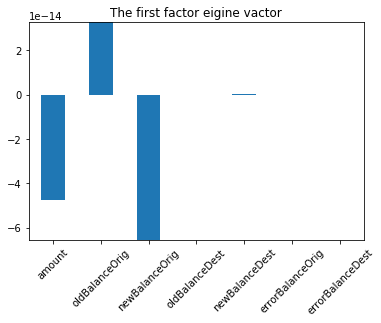

In [240]:
#第１主成分の挙動
pd.DataFrame(r.T, columns=X.columns).iloc[0, 2:].plot(kind="bar",rot=45, title="The first factor eigine vactor");

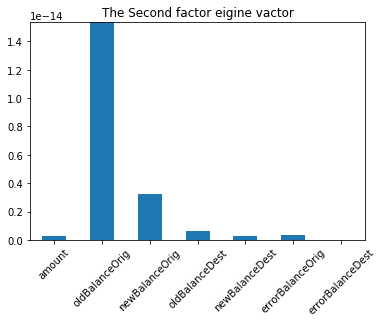

In [241]:
#第２主成分の挙動
pd.DataFrame(r.T, columns=X.columns).iloc[1, 2:].plot(kind = "bar",rot=45, title="The Second factor eigine vactor");

## データから読み取れる視座："CASHOUT"の取引タイプであり、かつ、取引前後の残高が高ければ高いほど、Fraudの可能性が高まる

In [242]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [243]:
weights = (Y == 0).sum() / ((Y == 1).sum())

In [244]:
(Y==0).sum()

2762196

In [245]:
(Y==1).sum()

8213

In [246]:
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9983733985610046


## 高確率で予測できている。比較すると以下の通り

In [250]:
Y_pred = clf.fit(trainX, trainY).predict(testX)

In [291]:
print(testY.shape, Y_pred.shape)
Y_pred

(554082,) (554082,)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [293]:
Y_predict = pd.DataFrame(Y_pred)
Y_test = pd.DataFrame(testY)
Y_test.index = np.arange(Y_test.shape[0])

In [320]:
len(Y_predict == 1)

554082

In [309]:
len(Y_test.values)

554082

In [313]:
pd.DataFrame(confusion_matrix(Y_test.values, Y_predict.values), index=[["Actual","Actual"],[0,1]], columns=[["Predict","Predict"],[0, 1]])

Predict      
               0     1
Actual 0  552163   283
       1       2  1634

## 改善ポイントは、上記の283件の所になる。predictが１となっている件数全部を確認しても、データ総体に比較して件数はかなり少ない(約1900件)

In [311]:
print(clf.score(testX, testY))

0.9994856357


## 重要な変数は以下の通り

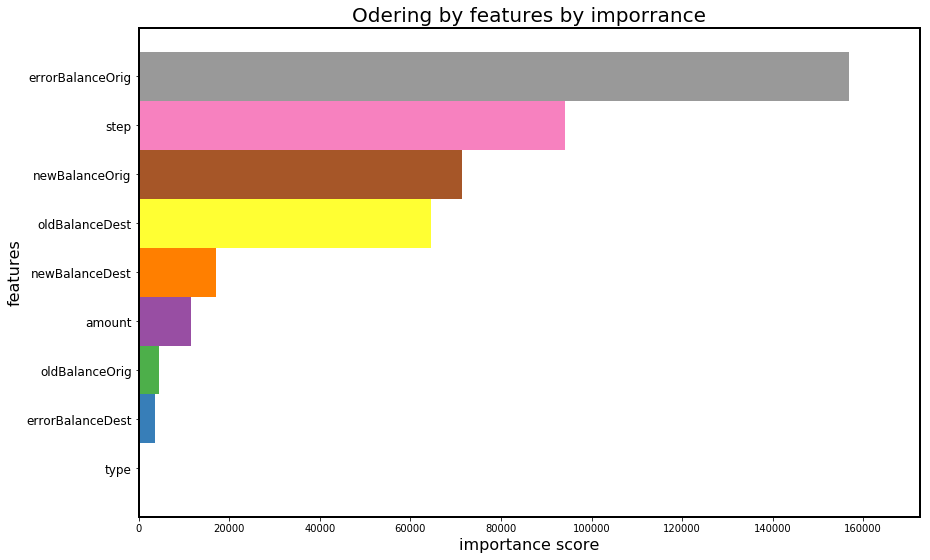

In [168]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0,1,9))

ax = plot_importance(clf, height=1, color=colours, grid=False,
                    show_values=False, importance_type="cover", ax=ax)
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(2)
    
ax.set_xlabel("importance score", size=16)
ax.set_ylabel("features", size=16)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.set_title("Odering by features by imporrance", size=20);